In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from glob import glob
import seaborn as sns
import scipy
import os
import re

In [2]:
def dataExtract(file):
    """
        file: history file per trial
    """
    f = open(file, "r")
    lines = f.readlines()

    trialData = np.array([re.findall(r"-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?", line) for line in lines], dtype = float)

    return trialData

In [ ]:
def meanTrial(trialFolder):
    """
       sum and mean data from trials
    """
    trialData = np.zeros((1000,7))
    trialNum = 0

    for file in glob(f"{trialFolder}\\*\\*\\e=1000p=100_history.txt"):
        # print(file)
        trialNum += 1
        data = dataExtract(file)
        trialData += data

    meanTrialData = trialData/trialNum
    return meanTrialData
    

In [ ]:
# these are exponential function fitted to metaheuristic convergence 
# in very first idea, we try to fit for a, b, c parameter as initialization, optimization rate,
# and boundary of optimization. However, the type of RNGs does not affect to these parameters
def expo_function(x, a, b, c):
    return a * np.exp(-b * x) + c

def expo_function_maxcut(x, a, b, c):
    return a * np.exp(-b/x) + c


def calculateTestCaseModel(epoch, globalFitness, problem, isPlot = True):
    popt, pcov = scipy.optimize.curve_fit(
        expo_function if problem != "maxcut" else expo_function_maxcut,
        epoch, 
        globalFitness, 
        bounds=([0,0,0],[np.inf,np.inf,np.inf]),
        maxfev=5000)
    
    if isPlot:
        plt.plot(epoch, 
                globalFitness,
                'b-',
                label='data')
        plt.plot(epoch,
                expo_function(epoch, *popt) if problem != "maxcut" else expo_function_maxcut(epochAvg, *popt), 
                'r-',
                label='fit: a=%f, b=%f, c=%f' % tuple(popt))
        plt.legend()
    
    return popt


In [ ]:
def createModelSummary(dataFolder):
    # define dataframe columns
    columns=["algo", "problem", "testcase", "rng",
            #   "a (initError)", "b (rate)", "c (optimal)",         # comment becuase not apply in observation
              "last global fitness", "first global fitness", "first diversity"]
    matrixData = []

    # get all data in directory
    for algoFolder in glob(f"{dataFolder}\\*"):
        algo = os.path.basename(algoFolder)
        for problemFolder in glob(f"{algoFolder}\\*"):
            problem = os.path.basename(problemFolder)
            for testCaseFolder in glob(f"{problemFolder}\\*"):
                testCase = os.path.basename(testCaseFolder)
                for rngFolder in glob(f"{testCaseFolder}\\*"):
                    rng = os.path.basename(rngFolder)
                    print(testCase, problem, rngFolder)
                    
                    # get means of data
                    try:
                        trial = meanTrial(rngFolder)
                        epoch = trial[:, 0]
                        localFitness = trial[:, 1]
                        globalFitness = trial[:, 2]
                        diversity = trial[:, 3]
                        exploration = trial[:, 4]
                        exploitation = trial[:, 5]
                        runtime = trial[:, 6]

                        # a, b, c = calculateTestCaseModel(epoch, globalFitness, problem, isPlot=False) # comment becuase not apply in observation
                        matrixData.append([algo, problem, testCase, rng,
                                            # a, b, c,                                                  # comment becuase not apply in observation
                                            globalFitness[-1], globalFitness[0], diversity[0]])
                    except:
                        print("An exception occurred")   

    df_main = pd.DataFrame(matrixData, columns=columns)
    
    return df_main

In [6]:
df = createModelSummary("D:\\QuantumResult\\historyAPR")

F102021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F102021\BeamSplitter
F102021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F102021\Ibm
F102021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F102021\Mt19937
F102021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F102021\QuasiRandom
F12021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F12021\BeamSplitter
F12021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F12021\Ibm
F12021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F12021\Mt19937
F12021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F12021\QuasiRandom
F22021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F22021\BeamSplitter
F22021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F22021\Ibm
F22021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F22021\Mt19937
F22021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F22021\QuasiRandom
F32021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F32021\BeamSplitter
F32021 CEC2021 D:\QuantumResult\historyAPR\ABC\CEC2021\F32021\

In [7]:
df.shape

(240, 10)

In [ ]:
# create summary table
df[df["problem"] == "CEC2021"][["problem","testcase","algo", "rng","first diversity", "first global fitness", "last global fitness"]].head(20)

,problem,testcase,algo,rng,first diversity,first global fitness,last global fitness
0,CEC2021,F102021,ABC,BeamSplitter,47.087979,1.169468e+03,480.731605
1,CEC2021,F102021,ABC,Ibm,47.532645,1.183170e+03,480.538011
2,CEC2021,F102021,ABC,Mt19937,46.956470,1.200376e+03,480.572250
3,CEC2021,F102021,ABC,QuasiRandom,23.791280,3.561906e+03,493.556122
4,CEC2021,F12021,ABC,BeamSplitter,47.114680,1.164317e+10,26203.603085
5,CEC2021,F12021,ABC,Ibm,47.052381,1.137050e+10,25812.012629
6,CEC2021,F12021,ABC,Mt19937,47.295072,1.293217e+10,28026.978479
7,CEC2021,F12021,ABC,QuasiRandom,23.280841,3.562803e+10,44092.059692
8,CEC2021,F22021,ABC,BeamSplitter,50.646826,2.220065e+03,1138.843002
9,CEC2021,F22021,ABC,Ibm,50.346753,2.228376e+03,1177.449711


C:\Users\pons2\AppData\Local\Temp\ipykernel_15264\2588745092.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encode_df = df.replace(encode_dict)


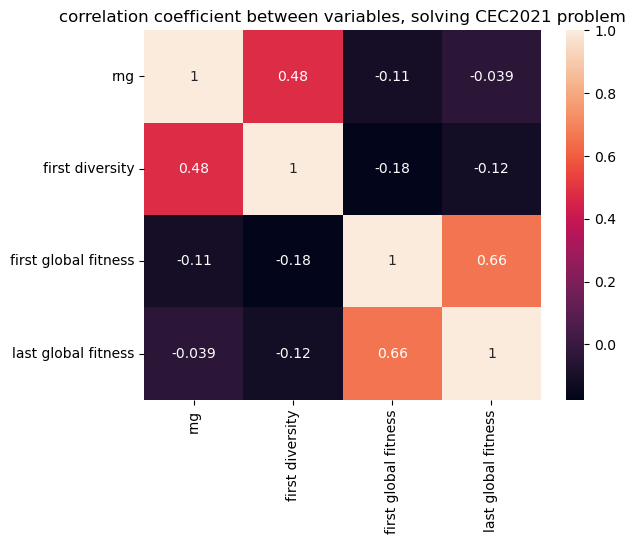

In [ ]:
# encode categorical value of RNG type into numeric values
encode_dict = {"BeamSplitter":1, "Ibm":1, "Mt19937":0, "QuasiRandom":0}
encode_df = df.replace(encode_dict)
problem = "CEC2021" # define problem here


# make correlation heatmap
plt.title(f"correlation coefficient between variables, solving {problem} problem")
sns.heatmap(encode_df[encode_df["problem"] == problem][["rng", "first diversity", "first global fitness", "last global fitness"]].corr(numeric_only=True), annot = True)
plt.show()


C:\Users\pons2\AppData\Local\Temp\ipykernel_15264\431498197.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encode_df = df.replace(encode_dict)


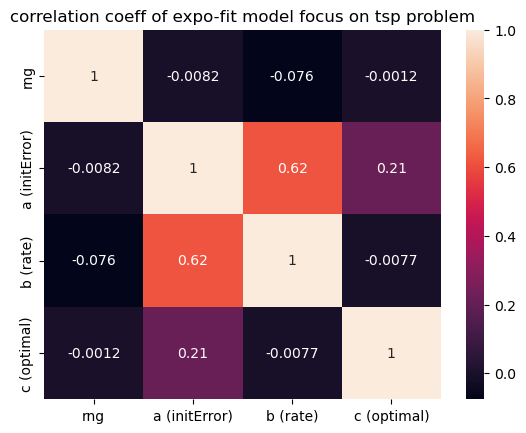

In [ ]:
# encode categorical value of RNG type into numeric values
encode_dict = {"BeamSplitter":1, "Ibm":1, "Mt19937":0, "QuasiRandom":0}
encode_df = df.replace(encode_dict)
problem = "tsp" # define problem here

# make correlation heatmap with fitted parameters
plt.title(f"correlation coeff of expo-fit model focus on {problem} problem")
sns.heatmap(encode_df[encode_df["problem"] == problem][["rng", "a (initError)", "b (rate)", "c (optimal)"]].corr(numeric_only=True), annot = True)
plt.show()